In [1]:
import pandas as pd
import numpy as np
import nltk
from cogroo4py.cogroo import Cogroo
import statsmodels.api as sm
# nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import language_tool_python as lt
import uol_redacoes_xml as uol
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('max_colwidth', 1000)

In [2]:
tool = lt.LanguageTool('pt-BR')
cogroo = Cogroo()
# essays = uol.load()

In [3]:
tool.check('Elas são bonita')

[]

In [4]:
essays_df = pd.read_csv('../data/essays.csv', sep='|')
tool_df = pd.read_csv('../data/corrections/correction_language_tool_2.csv', sep='|')

In [5]:
cogroo_df = pd.read_csv('../data/corrections/correction_cogroo_2.csv', sep='|')

In [6]:
essays_info = essays_df.loc[:, ['essay', 'comp1', 'url']]
essays_info.head()

,essay,comp1,url
0,0,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/conflito-entre-liberdade-de-expressao-e-intimidade-bom-senso-e-necessario.htm
1,1,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/entre-direitos-individuais-e-escandalos-politicos.htm
2,2,0.5,https://educacao.uol.com.br/bancoderedacoes/redacoes/o-freio-na-liberdade-para-uma-maior-liberdade.htm
3,3,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/privilegio-a-informacao.htm
4,4,1.0,https://educacao.uol.com.br/bancoderedacoes/redacoes/limites-entre-direitos.htm


In [7]:
errors_df = tool_df.drop_duplicates(subset=['error'])
errors_df = errors_df.merge(essays_info, on='essay')

## Analysing Language Tool Outputs

### Cleaning Up error Cogroo

In [8]:
cogroo_df = cogroo_df[~cogroo_df['error'].str.contains('space')]

### Cleaning Up errors Tool Language


In [9]:
errors_df['category'].nunique(), errors_df['error'].nunique()

(23, 404)

In [10]:
errors_df['category'].value_counts()

category
CONFUSED_WORDS         103
GRAMMAR                 72
MISC                    54
REDUNDANCY              31
CLICHES                 21
REDACTION_TIPS          21
TYPOGRAPHY              17
PUNCTUATION             14
MISSPELLING             12
FORMAL_SPEECH           12
STYLE                   10
CASING                   7
EGGCORNS                 7
SYNTAX                   6
SEMANTICS                4
COMPOUNDING              3
REPETITIONS              3
CONTRACTIONS             2
REPETITIONS_STYLE        1
WIKIPEDIA                1
TYPOS                    1
FORMAL_SPEECH_PT_BR      1
TRANSLATION_ERRORS       1
Name: count, dtype: int64

#### Generate Examples

In [11]:
for cat in errors_df['category'].unique():
    errors_df[errors_df['category'] == cat].to_csv(f'./examples_before/{cat.lower()}_examples.csv', index=False)

In [12]:
wikipedia_messages = pd.DataFrame(tool_df[tool_df['category'] == 'WIKIPEDIA']['message'].unique(), columns=['message'])
wikipedia_messages.to_csv('./examples_before/wikipedia_messages.txt', index=False)

In [13]:
tool_df[tool_df['category'] == 'SEMANTICS'].to_csv('./examples_before/semantics_all_examples.csv', index=False)

#### Clean dataframe

- Move simplificações and 'prolixa' to Redaction TIPS
- TYPOGRAPHY: Remove
- SEMANTICS: Consider only message "Considere “infringir”, i.e. transgredir, em vez de ‘infligir’, i.e. aplicar" and move to CONFUSED WORDS
- SEMANTICS: When "vc" appears and "ROMAN_NUMBERS_CHECKER" move to category MISSPELLING and error INTERNET_ABBREVIATIONS
- EGGCORNS: Move to Tips
- REPETITIONS: union with REPETITIONS_STYLE
- FORMAL_SPEECH_PT_BR: Remove
- TRANSLATION_ERRORS: Remove
- WIKIPEDIA: Move samples with 'boas-vindas' error to category COMPOUNDING with rule 	PT_COMPOUNDS_POST_REFORM and move rest to grammar except messages with 'seculo'
- STYLE: Move PT_CLICHE_REPLACE to CLICHES and move PORTUGUESE_WORD_REPEAT_BEGINNING_RULE to REPETITIONS
- PONCTUATION: Remove INTERJECTIONS_PUNTUATION

In [14]:
def clean_dataframe(tool_df):
    tool_df_clean = tool_df.copy()

    # Remove FORMAL_SPEECH_PT_BR,  TRANSLATION_ERRORS, TYPOGRAPHY
    tool_df_clean = tool_df_clean[~tool_df_clean['category'].isin(['TYPOGRAPHY', 'TRANSLATION_ERRORS', 'FORMAL_SPEECH_PT_BR'])]
    
    # Move Simplification
    tool_df_clean.loc[tool_df_clean['message'].str.contains('simpli'), 'category'] = 'REDACTION_TIPS'
    tool_df_clean.loc[tool_df_clean['message'].str.contains('prolixa'), 'category'] = 'STYLE'
    
    
    # Clean SEMANTICS
    tool_df_clean.loc[tool_df_clean['message'].str.contains('infringir'), 'category'] = 'CONFUSED_WORDS'
    tool_df_clean.loc[
        (tool_df_clean['message'].str.contains('infringir')) & (tool_df_clean['category'] == 'SEMANTICS')
    , ['error', 'category']] = ['INTERNET_ABBREVIATIONS', 'MISSPELLING']
    tool_df_clean = tool_df_clean[tool_df_clean['category'] != 'SEMANTICS']
    
    # Aggregate EGGCORNS and REDACTION_TIPS
    tool_df_clean.loc[tool_df_clean['category'] == 'EGGCORNS', 'category'] = 'REDACTION_TIPS'
    
    # Aggregate Repetitions
    tool_df_clean.loc[tool_df_clean['category'] == 'REPETITIONS_STYLE', 'category'] = 'REPETITIONS'
    
    # Clean Wikipedia
    
    tool_df_clean.loc[
        (tool_df_clean['message'].str.contains('boas vindas')) & (tool_df_clean['category'] == 'WIKIPEDIA')
    , ['error', 'category']] = ['PT_COMPOUNDS_POST_REFORM', 'COMPOUNDING']
    tool_df_clean.loc[~(tool_df_clean['message'].str.contains('século')) & (tool_df_clean['category'] == 'WIKIPEDIA'), 'category'] = 'GRAMMAR'
    tool_df_clean = tool_df_clean[tool_df_clean['category'] != 'WIKIPEDIA']
    
    # Move Style errors
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PORTUGUESE_WORD_REPEAT_BEGINNING_RULE')
    ,'category'] = 'REPETITIONS'
    
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PORTUGUESE_WORD_REPEAT_BEGINNING_RULE')
    ,'category'] = 'REPETITIONS'
    
    # Remove INTERJECTIONS_PUNTUATION errors
    tool_df_clean.loc[
        (tool_df_clean['category'] == 'STYLE') &
        (tool_df_clean['error'] == 'PT_CLICHE_REPLACE')
    ,'category'] = 'CLICHES'
    
    tool_df_clean = tool_df_clean.loc[~((tool_df_clean['category'] == 'PUNCTUATION') & (tool_df_clean['error'] == 'INTERJECTIONS_PUNTUATION'))]
    
    return tool_df_clean

In [15]:
tool_df_clean = clean_dataframe(tool_df)

In [16]:
error_df_cleaned = tool_df_clean.drop_duplicates(subset=['error'])
for cat in error_df_cleaned['category'].unique():
    error_df_cleaned[error_df_cleaned['category'] == cat].to_csv(f'./examples_after/{cat.lower()}_examples.csv', index=False)

### Analyse Overall Results

#### Comparing Cogroo with tool languagem
<hr/>

In [17]:
cogroo_df.shape[0] + tool_df_clean[tool_df_clean['category'] == 'TYPOS'].shape[0], tool_df_clean.shape[0]

(5898, 15226)

In [18]:
tool_df_clean['error'].nunique()

381

#### Analysing Cleaning
<hr/>

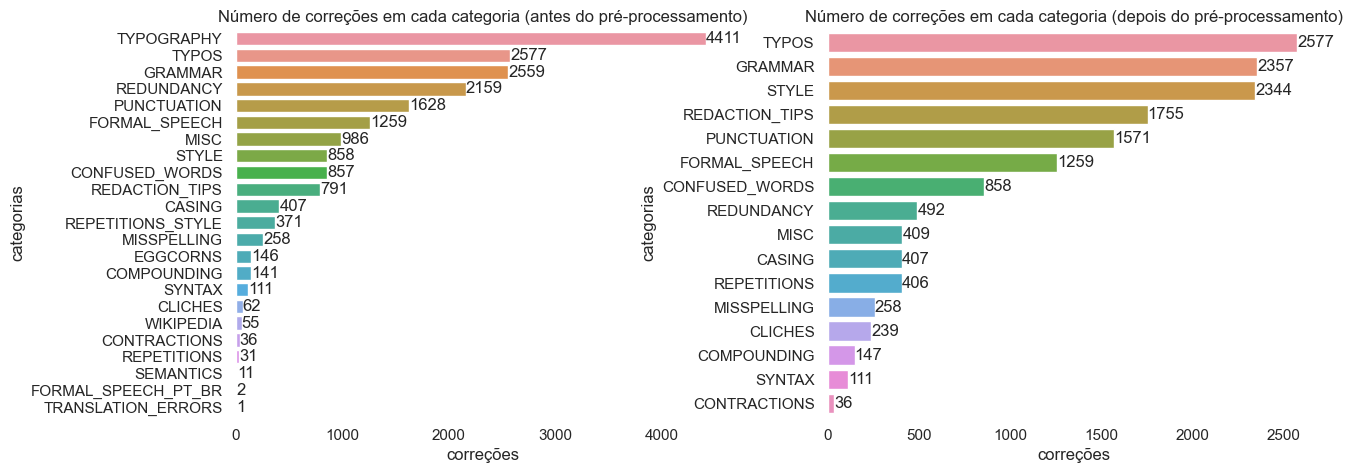

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
tool_values = tool_df['category'].value_counts()       
axes[0] = sns.barplot(x=tool_values.values, y= tool_values.index, order=tool_values.index, ax=axes[0]) 
axes[0].set(ylabel='categorias', xlabel='correções', title='Número de correções em cada categoria (antes do pré-processamento)', frame_on=False) 
axes[0].bar_label(axes[0].containers[0])

tool_values_cl = tool_df_clean['category'].value_counts()       
sns.barplot(x=tool_values_cl.values, y= tool_values_cl.index, order=tool_values_cl.index, ax=axes[1]) 
axes[1].set(ylabel='categorias', xlabel='correções', title='Número de correções em cada categoria (depois do pré-processamento)', frame_on=False) 
axes[1].bar_label(axes[1].containers[0]);  

In [20]:
most_comum_errors = tool_df_clean.groupby(by=['error', 'category']).size()
most_comum_errors = most_comum_errors.reset_index(level=[0, 1]).rename(columns={0:'count_errors'})
most_comum_errors = most_comum_errors.sort_values(by='count_errors', ascending=False).head(10)

In [115]:
most_comum_errors = most_comum_errors.rename(columns={
    'category': 'categoria'
})

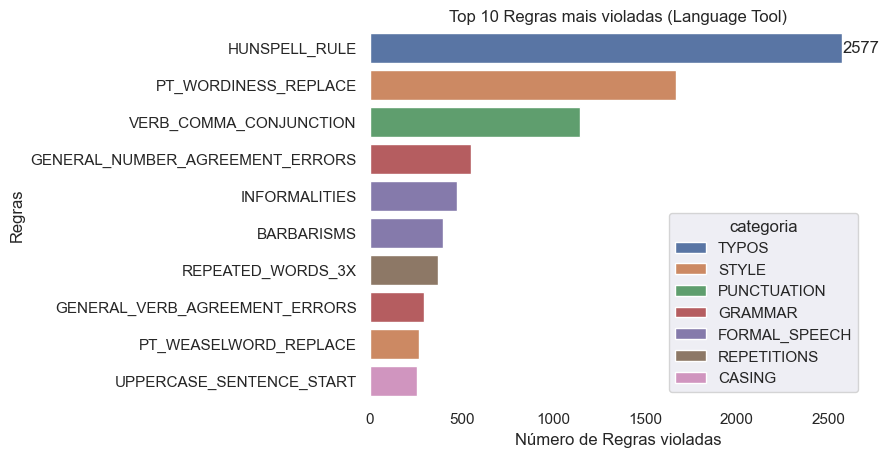

In [116]:
values = tool_df_clean['error'].value_counts().head(10)      # compute counts by class
ax = sns.barplot(x=most_comum_errors['count_errors'], y= most_comum_errors['error'], hue=most_comum_errors['categoria'], dodge=False) # plot count plot
ax.set(ylabel="Regras", xlabel='Número de Regras violadas', title='Top 10 Regras mais violadas (Language Tool)', frame_on=False) # prettify
# ax.tick_params(length=0)                               # remove tick liens
ax.bar_label(ax.containers[0]);     

### Generate and Analyse language tool features

In [72]:
features_cogroo_df = cogroo_df.groupby(['essay', 'error']).size().unstack(fill_value=0)
features_tool_df = tool_df_clean.groupby(['essay', 'category']).size().unstack(fill_value=0)
features_tool_df = features_tool_df.reset_index()
features_cogroo_df = features_cogroo_df.reset_index()

In [73]:
features_tool_df.head()

category,essay,CASING,CLICHES,COMPOUNDING,CONFUSED_WORDS,CONTRACTIONS,FORMAL_SPEECH,GRAMMAR,MISC,MISSPELLING,PUNCTUATION,REDACTION_TIPS,REDUNDANCY,REPETITIONS,STYLE,SYNTAX,TYPOS
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1
1,1,1,0,0,1,0,1,1,0,0,0,2,0,0,3,0,1
2,2,0,0,0,0,1,1,2,0,0,1,2,1,1,1,0,0
3,3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
4,4,0,0,0,3,0,1,1,0,0,1,2,0,0,1,0,0


In [74]:
features_cogroo_df.head()

error,essay,government:GOVERNMENT,probs:paronyms,punctuation:BEFORE_SENTENCES,repetition:DUPLICATED_TOKEN,xml:1,xml:10,xml:103,xml:104,xml:105,xml:107,xml:11,xml:111,xml:113,xml:114,xml:115,xml:117,xml:118,xml:121,xml:122,xml:124,xml:127,xml:128,xml:129,xml:13,xml:14,xml:17,xml:2,xml:21,xml:3,xml:39,xml:4,xml:40,xml:46,xml:47,xml:5,xml:50,xml:51,xml:52,xml:57,xml:58,xml:6,xml:61,xml:65,xml:67,xml:71,xml:73,xml:78,xml:79,xml:82,xml:84,xml:86,xml:87,xml:88,xml:9,xml:91,xml:95,xml:96,xml:97
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [76]:
essays_df.loc[~essays_df['essay'].isin(features_tool_df['essay'].to_list()), 'essay'].shape

(20,)

In [77]:
features_tool_df = essays_df.loc[:, ['essay', 'comp1']].merge(features_tool_df, how='left', on='essay')
features_cogroo_df =  essays_df.loc[:, ['essay', 'comp1']].merge(features_cogroo_df, how='left', on='essay')
features_cogroo_df.shape, features_tool_df.shape

((2164, 60), (2164, 18))

In [83]:
features_tool_df = features_tool_df.fillna(0)
features_cogroo_df = features_cogroo_df.fillna(0)


In [100]:
features_cogroo_df.shape

(2164, 61)

In [102]:
61-3

58

In [101]:
features_cogroo_df.columns

Index(['essay', 'comp1', 'government:GOVERNMENT', 'probs:paronyms',
       'punctuation:BEFORE_SENTENCES', 'repetition:DUPLICATED_TOKEN', 'xml:1',
       'xml:10', 'xml:103', 'xml:104', 'xml:105', 'xml:107', 'xml:11',
       'xml:111', 'xml:113', 'xml:114', 'xml:115', 'xml:117', 'xml:118',
       'xml:121', 'xml:122', 'xml:124', 'xml:127', 'xml:128', 'xml:129',
       'xml:13', 'xml:14', 'xml:17', 'xml:2', 'xml:21', 'xml:3', 'xml:39',
       'xml:4', 'xml:40', 'xml:46', 'xml:47', 'xml:5', 'xml:50', 'xml:51',
       'xml:52', 'xml:57', 'xml:58', 'xml:6', 'xml:61', 'xml:65', 'xml:67',
       'xml:71', 'xml:73', 'xml:78', 'xml:79', 'xml:82', 'xml:84', 'xml:86',
       'xml:87', 'xml:88', 'xml:9', 'xml:91', 'xml:95', 'xml:96', 'xml:97',
       '#correções cogroo'],
      dtype='object')

In [27]:
features_tool_df.describe().iloc[1:, ]

category,CASING,CLICHES,COMPOUNDING,CONFUSED_WORDS,CONTRACTIONS,FORMAL_SPEECH,GRAMMAR,MISC,MISSPELLING,PUNCTUATION,REDACTION_TIPS,REDUNDANCY,REPETITIONS,STYLE,SYNTAX,TYPOS
mean,0.189832,0.111474,0.068563,0.400187,0.016791,0.587220,1.099347,0.190765,0.120336,0.732743,0.818563,0.229478,0.189366,1.093284,0.051772,1.201959
std,0.654408,0.344518,0.287329,0.876573,0.128518,1.028227,1.333344,0.496829,0.424931,1.007175,0.987184,0.498760,0.586486,1.209185,0.241759,2.194418
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000
max,10.000000,3.000000,3.000000,8.000000,1.000000,9.000000,11.000000,5.000000,4.000000,7.000000,6.000000,3.000000,7.000000,10.000000,3.000000,28.000000


In [97]:
features_cogroo_df.to_csv('../data/features/cogroo_feature.csv', index=False)
features_tool_df.to_csv('../data/features/tool_language_feature.csv', index=False)
features_tool_df.head()

,essay,comp1,CASING,CLICHES,COMPOUNDING,CONFUSED_WORDS,CONTRACTIONS,FORMAL_SPEECH,GRAMMAR,MISC,MISSPELLING,PUNCTUATION,REDACTION_TIPS,REDUNDANCY,REPETITIONS,STYLE,SYNTAX,TYPOS,#correções tool_language
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0
1,1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0,10.0
2,2,0.5,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,10.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
4,4,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,9.0


In [90]:
features_tool_df['#correções tool_language'] = features_tool_df.drop(columns=['comp1', 'essay']).apply(sum, axis=1)
features_cogroo_df['#correções cogroo'] = features_cogroo_df.drop(columns=['comp1', 'essay']).apply(sum, axis=1)

In [91]:
features_cogroo_df['comp1'] = features_cogroo_df['comp1'].astype(str)
features_tool_df['comp1'] = features_tool_df['comp1'].astype(str)

0       1.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
2159    1.0
2160    4.0
2161    3.0
2162    4.0
2163    0.0
Name: TYPOS, Length: 2164, dtype: float64

In [121]:
features_cogroo_df['#correções cogroo'] = features_cogroo_df['#correções cogroo'] + features_tool_df['TYPOS']

[Text(0.5, 0, 'Nota Competência 1'),
 Text(0.5, 1.0, 'Relação entre o número de correções e a nota'),
 Text(0, 0.5, '#correções Cogroo + #correções hunspell')]

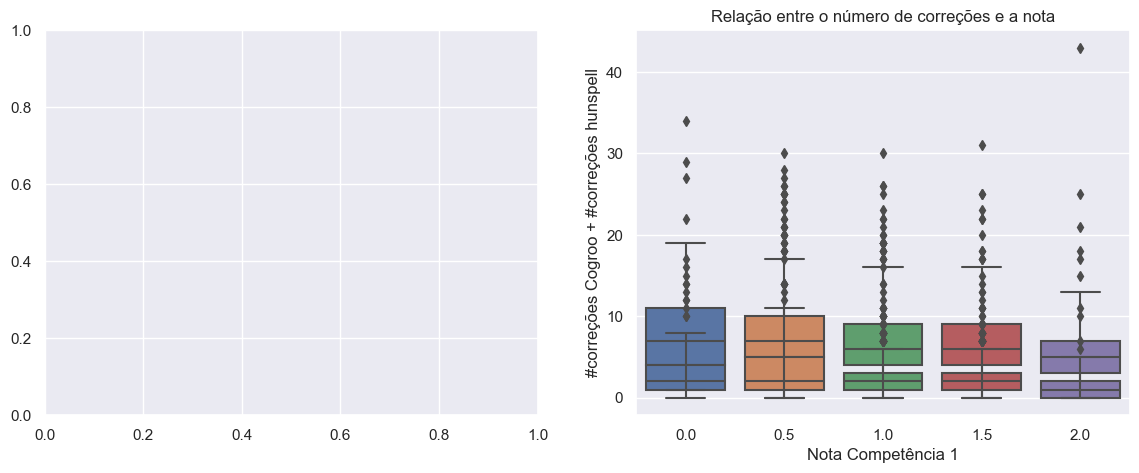

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=features_tool_df, x='comp1', y='#correções tool_language', order=['0.0','0.5', '1.0', '1.5', '2.0'], ax=axes[0])
axes[0].set(xlabel='Nota Competência 1', title='Relação entre o número de correções e a nota', ylabel='#correções language tool') 

axes[1] = sns.boxplot(data=features_cogroo_df, x='comp1', y='#correções cogroo', order=['0.0','0.5', '1.0', '1.5', '2.0'], ax=axes[0])
axes[1].set(xlabel='Nota Competência 1', title='Relação entre o número de correções e a nota', ylabel='#correções Cogroo + #correções hunspell') 